# Derivation of conditional simulation with SPDE

The goal is to check the derivability of a conditional simulation with respect to the white noise.

In [125]:
import logging
import os
from pathlib import Path
from typing import Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import pyrtid.utils.spde as spde
from pyrtid.utils import indices_to_node_number
from pyrtid.utils.types import NDArrayFloat, NDArrayInt
from scipy._lib._util import check_random_state  # To handle random_state
from sksparse.cholmod import cholesky

- Set-up logging level

In [126]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")
print("This is a print test")

INFO:root:this is a logging test


This is a print test


- Check package/software versions

In [127]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Random number generator with a given seed for reproducible results

In [128]:
rng = np.random.default_rng(2023)

- Create a directory to store the exported figures

In [129]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [130]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

- Grid definition

In [131]:
# Grid
nx = 20  # number of voxels along the x axis
ny = 20  # number of voxels along the y axis
nz = 1
dx = 5.0  # voxel dimension along the x axis
dy = 5.0  # voxel dimension along the y axis
dz = 5.0

- Generate a random field with the SPDE approach

In [132]:
len_scale = 20.0  # m
kappa = 1 / len_scale
alpha = 1.0

mean = 100.0  # trend of the field
std = 150.0  # standard deviation of the field

# Create a precison matrix
Q_ref = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa, alpha, spatial_dim=2, sigma=std
)
cholQ_ref = cholesky(Q_ref)
# Non conditonal simulation -> change the random state to obtain a different field
simu_ = spde.simu_nc(cholQ_ref, random_state=2026).reshape(ny, nx).T
reference_grade_ppm = np.abs(simu_ + mean)

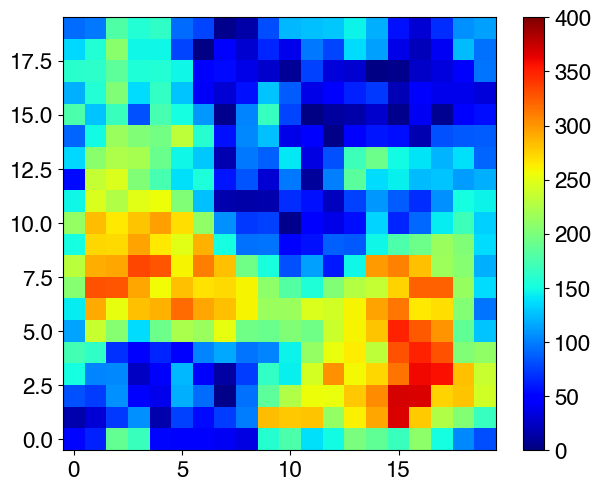

In [133]:
plt.imshow(
    reference_grade_ppm.T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
    aspect="equal",
    vmin=0.0,
    vmax=400,
)
plt.colorbar()

- Select some points from this field (drilling places) -> green dots on the map

Text(0, 0.5, 'Y [m]')

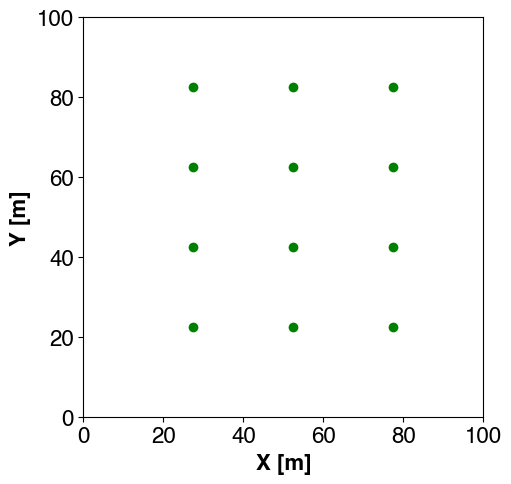

In [134]:
_ix = np.array([int(nx / 4), 2 * int(nx / 4), 3 * int(nx / 4)])
_iy = np.array([int(ny / 5), 2 * int(ny / 5), 3 * int(ny / 5), 4 * int(ny / 5)])

dat_coords = np.array(np.meshgrid(_ix, _iy)).reshape(2, -1)
# Get the node numbers
dat_nn: NDArrayInt = indices_to_node_number(dat_coords[0, :], nx, dat_coords[1, :])
dat_val = reference_grade_ppm.ravel("F")[dat_nn]

plotter_wf = ngp.NestedGridPlotter(fig_params={"figsize": (5, 5)})
for i, j in dat_coords.T:
    plotter_wf.ax_dict["ax1-1"].plot((i + 0.5) * dx, (j + 0.5) * dy, "go")

plotter_wf.ax_dict["ax1-1"].set_aspect("equal", adjustable="box")
plotter_wf.ax_dict["ax1-1"].set_xlim(0, nx * dx)
plotter_wf.ax_dict["ax1-1"].set_ylim(0, ny * dy)
plotter_wf.ax_dict["ax1-1"].set_xlabel("X [m]", fontweight="bold")
plotter_wf.ax_dict["ax1-1"].set_ylabel("Y [m]", fontweight="bold")

- Generate a krigging and conditional simulations

In [135]:
# Condition with the exact data -> we assume a large noise over the data
dat_var_init = np.ones(dat_val.size) * (100**2)

# Generate new points with error -> some variance on the mesures
dat_val_noisy = dat_val + np.sqrt(dat_var_init) * (
    np.random.default_rng(2048).normal(scale=0.1, size=dat_val.size)
)

# Compute the average on the data points (trend)
estimated_mean = np.average(dat_val_noisy)
estimated_std = float(np.std(dat_val_noisy))

alpha = 1

# Create a precison matrix
Q_init = spde.get_precision_matrix(
    nx, ny, 1, dx, dy, 1.0, kappa, alpha, spatial_dim=2, sigma=estimated_std
)
Q_init_c = spde.condition_precision_matrix(Q_init, dat_nn, dat_var_init)

# Decompose with cholesky
cholQ_init = cholesky(Q_init)
cholQ_init_c = cholesky(Q_init_c)

# Krigeage = average of conditional simulations
estimate_grade_krigging_ppm = (
    spde.kriging(
        Q_init_c,
        dat_val_noisy - estimated_mean,
        dat_nn,
        cholQ_init_c,
        dat_var_init,
    )
    .reshape(ny, nx)
    .T
    + estimated_mean
)

# Conditional simulation
estimate_grade_simu_ppm: Dict[int, NDArrayFloat] = {}
white_noise: Dict[int, NDArrayFloat] = {}

for i in range(3):
    white_noise[i] = check_random_state(2063 + 9563 * i).normal(
        size=cholQ_init.L().shape[0]
    )
    estimate_grade_simu_ppm[i] = (
        spde.simu_c(
            cholQ_init,
            Q_init_c,
            cholQ_init_c,
            dat_val_noisy - estimated_mean,
            dat_nn,
            dat_var_init,
            w=white_noise[i],
        )
        .reshape(ny, nx)
        .T
        + estimated_mean
    )

- Plot

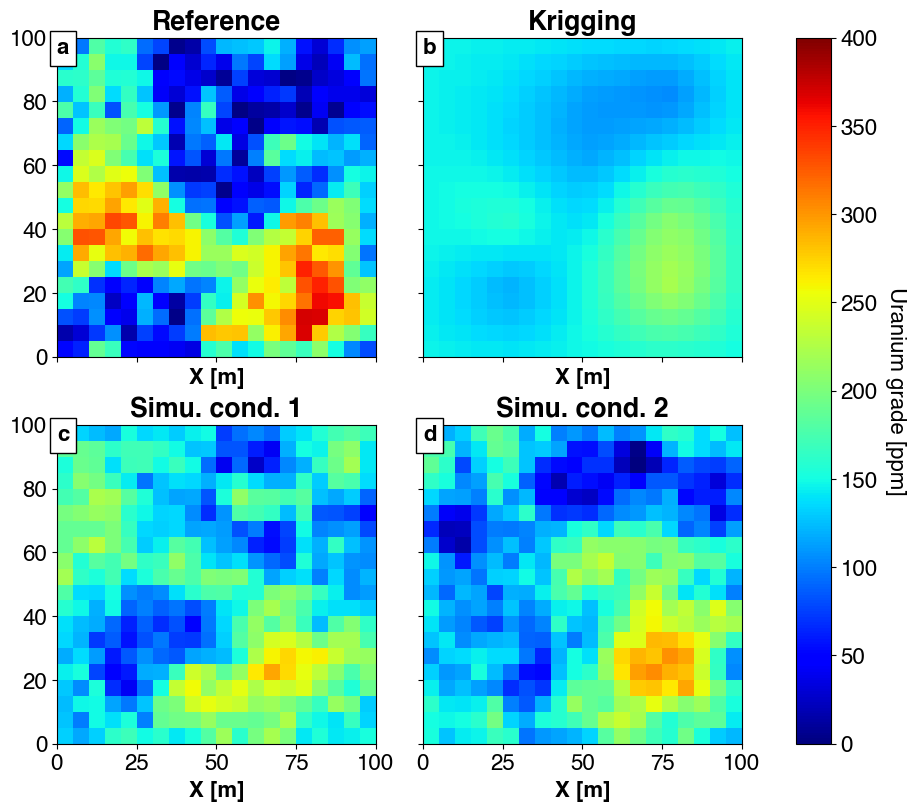

In [136]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (9, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"]], sharey=True, sharex=True
        )
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": reference_grade_ppm,
        "Krigging": estimate_grade_krigging_ppm,
        "Simu. cond. 1": estimate_grade_simu_ppm[0],
        "Simu. cond. 2": estimate_grade_simu_ppm[1],
    },
    cbar_title="Uranium grade [ppm]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "vmin": 0.0,
        "vmax": 400,
        "aspect": "equal",
    },
    xlabel="X [m]",
)

ngp.add_letter_to_frames(plotter.axes)

- Now we try to build a loss function to compute the distance between the reference and a realization

In [137]:
def eval_loss(s_ref: NDArrayFloat, s_cur: NDArrayFloat) -> float:
    return np.sum((s_cur - s_ref) ** 2)


eval_loss(reference_grade_ppm, estimate_grade_krigging_ppm)

2517402.529121264

- Define an objective function with the SPDE process

In [138]:
def ls_simu_nc(w: NDArrayFloat) -> float:
    """w is the Gaussian white noise."""
    s_cur = (
        spde.simu_nc(
            cholQ_init,
            w=w,
        )
        + estimated_mean
    )
    return eval_loss(reference_grade_ppm.ravel("F"), s_cur)

- Compute the analytical gradient of the white noise

In [139]:
from pyrtid.utils import finite_gradient

# Initial parameter = null white noise
x0 = check_random_state(2063 + 9563 * i).normal(size=cholQ_init.L().shape[0])

# finite difference gradient
fd_grad = finite_gradient(x0, ls_simu_nc, max_workers=6).reshape(nx, ny, order="F")
# https://math.stackexchange.com/questions/2128462/gradient-of-squared-frobenius-norm-of-a-matrix
# analytical gradient: "A^{-1}x - b"^2  ==> Gradient = 2A^{-T} (A^{-1} x - b)
an_grad = 2 * spde.simu_nc_t(
    cholQ_init,
    spde.simu_nc(cholQ_init, x0) + estimated_mean - reference_grade_ppm.ravel("F"),
).reshape(nx, ny, order="F")

- Plot the two gradients

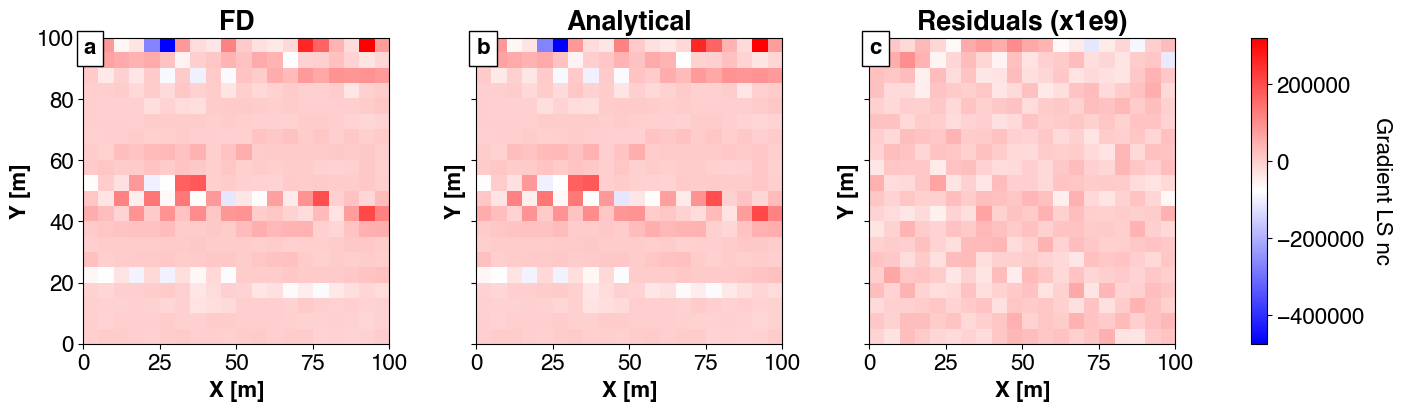

In [140]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 4)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "FD": fd_grad,
        "Analytical": an_grad,
        "Residuals (x1e9)": (fd_grad - an_grad) * 1e9,
    },
    cbar_title="Gradient LS nc",
    imshow_kwargs={
        # "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        # "vmin": 0.0,
        # "vmax": 400,
        "aspect": "equal",
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.add_letter_to_frames(plotter.axes)

## Now we want to assess the change of variable

Considering the equations

$$
\mathbf{s} = \mathcal{G}(\mathbf{w})
$$

and

$$
\mathbf{d} = \mathcal{H}(\mathbf{s})
$$

we want to compute 

$$
\dfrac{\partial \mathbf{d}}{\partial \xi} = \dfrac{\partial \mathcal{H} \circ \mathcal{G} (\mathbf{w})}{\partial \xi} = \dfrac{\partial \mathcal{G} (\mathbf{w})}{\partial \xi} \dfrac{\partial \mathcal{H} (\mathbf{s})}{\partial \mathbf{s}}
$$

considering a random vector

$$
\mathbf{b} = \dfrac{\partial \mathcal{H} (\mathbf{s})}{\partial \mathbf{s}}
$$

we want to test the correctness of

$$
\dfrac{\partial \mathcal{G} (\mathbf{w})}{\partial \xi} \mathbf{b}
$$

with the SPDE approach.




### First: test with non conditional simulation

In [141]:
"""Implement functions to perform geostatistics from the spde approach."""

from typing import Optional, Union

import numdifftools as nd
import numpy as np
from pyrtid.utils.grid import indices_to_node_number
from pyrtid.utils.types import NDArrayFloat, NDArrayInt
from scipy._lib._util import check_random_state  # To handle random_state
from scipy.sparse import csc_array, lil_array
from sksparse.cholmod import Factor, cholesky


def d_simu_nc_mat_vec(cholQ: Factor, b: NDArrayFloat) -> NDArrayFloat:
    return spde.simu_nc_t(cholQ, b)

In [142]:
def simu_nc_wrapper(w: NDArrayFloat) -> NDArrayFloat:
    """w is the Gaussian white noise."""
    return (
        spde.simu_nc(
            cholQ_init,
            w=w,
        )
        + estimated_mean
    )


# compute the jacobian matrix
jac = nd.Jacobian(simu_nc_wrapper)(x0)

b = check_random_state(2023).normal(size=(nx * ny))
# Apply the jacobian to a vector
fd_nc_mat_vec = (jac.T @ b).reshape(nx, ny, order="F")
# Derive analytically
an_nc_mat_vec = d_simu_nc_mat_vec(cholQ_init, b).reshape(nx, ny, order="F")

- plot the results

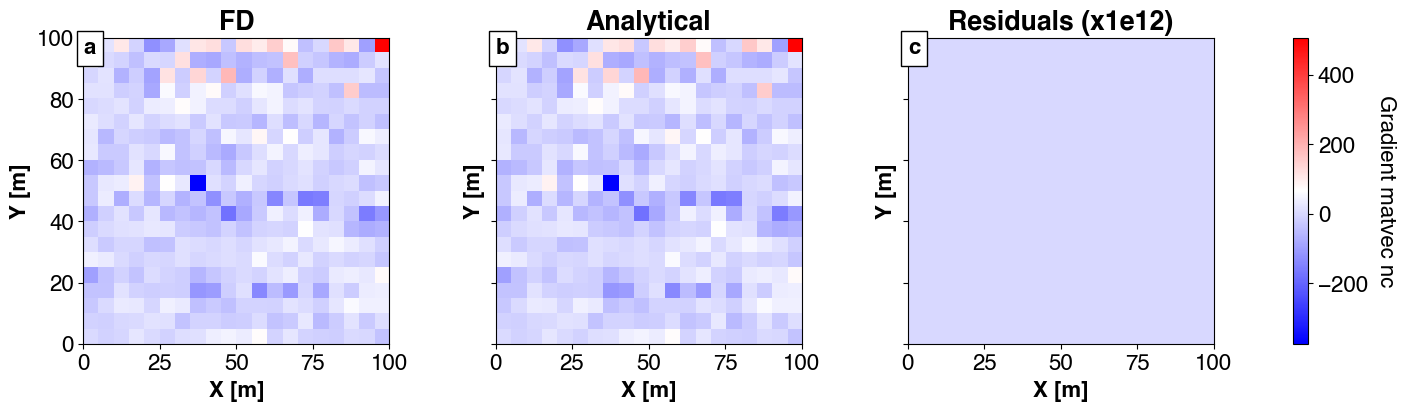

In [143]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 4)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "FD": fd_nc_mat_vec,
        "Analytical": an_nc_mat_vec,
        "Residuals (x1e12)": (fd_nc_mat_vec - an_nc_mat_vec) * 1e6,
    },
    cbar_title="Gradient matvec nc",
    imshow_kwargs={
        # "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        # "vmin": 0.0,
        # "vmax": 400,
        "aspect": "equal",
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.add_letter_to_frames(plotter.axes)

### Second: test with non conditional simulation

In [144]:
def d_simu_c_matvec(
    cholQ: Factor,
    cholQ_cond: Factor,
    dat_indices: NDArrayInt,
    dat_var: NDArrayFloat,
    b: NDArrayFloat,
) -> NDArrayFloat:
    """
    Return the product between the derivative of simu_c and a vector.

    The Jacobian matrix mapping the white noise and the parameter.

    Parameters
    ----------
    cholQ : Factor
        Cholesky decomposition of the unconditional precision matrix.
    Q_cond : csc_array
        Conditional precision matrix.
    cholQ_cond : Factor
        Cholesky factorization of the conditional precision matrix.
    dat_indices : NDArrayInt
        Grid cell indices of the conditional values.
    dat_var : NDArrayFloat
        Variance of the conditional data.
    w: Optional[NDArrayFloat]
        Gaussian white noise with mean zero and standard deviation 1.0. If not
        provided, the random state is used to generate the noise.
    random_state : Optional[Union[int, np.random.Generator, np.random.RandomState]]
        Pseudorandom number generator state used to generate resamples.
        If `random_state` is ``None`` (or `np.random`), the
        `numpy.random.RandomState` singleton is used.
        If `random_state` is an int, a new ``RandomState`` instance is used,
        seeded with `random_state`.
        If `random_state` is already a ``Generator`` or ``RandomState``
        instance then that instance is used. The default is None

    Returns
    -------
    NDArrayFloat
        Conditional simulation.
    """
    Z = lil_array((cholQ_cond.L().shape[0], dat_indices.size))
    Z[dat_indices, np.arange(dat_indices.size)] = 1
    return spde.simu_nc_t(cholQ, Z @ (1 / dat_var * (Z.T @ cholQ_cond(b))) - b)

f(x(z)) and x = Az, then df

\begin{equation}
\dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \mathbf{w}} = \left(\dfrac{\partial \mathbf{s}}{\partial \mathbf{w}}\right)^{\mathrm{T}} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}}  = \left(\dfrac{\partial \mathcal{G}(\mathbf{w})}{\partial \mathbf{w}}\right)^{\mathrm{T}} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}}
\end{equation}

\begin{equation}
\dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \mathbf{w}} = \mathbf{A}_{\mathrm{nc}}^{-1} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}} = \mathbf{D}_{\mathrm{nc}}^{-1/2}\mathbf{L}_{\mathrm{nc}}^{-1}\mathbf{P}_{\mathrm{nc}} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}}
\end{equation}

Non conditional simulation:

$$
\mathbf{A}_{\mathrm{nc}} \mathbf{s}_{\mathrm{nc}} = \mathbf{w} \implies \mathbf{s}_{\mathrm{nc}} = \mathbf{A}_{\mathrm{nc}}^{-1} \mathbf{w}
$$

Krigging, $\mathbf{Z}_{\mathrm{obs}}$ is a sparse matrix of size $(N_{s} \times N_{\mathrm{obs}})$ whose columns are unit vectors (i.e., columns of the identity matrix $\mathbf{I}_{N_{\mathrm{s}}}$) spanning the subspace of observed values:

$$
\mathbf{s}_{\mathrm{k}} = \mathbf{Q}_{\mathrm{cond}}^{-1} \mathbf{Z}_{\mathrm{obs}} \left(\mathbf{s}_{\mathrm{obs}} - \mathbf{I}_{N_{\mathrm{obs}}}\overline{\mathbf{s}}\right) \boldsymbol{\sigma}_{\mathrm{obs}}^{-1} + \mathbf{I}_{N_s} \overline{\mathbf{s}}
$$

Conditional simulation:

$$
\begin{aligned}
\mathbf{s}_{\mathrm{c}} &= \mathbf{s}_{\mathrm{k}} - \left(\mathbf{s}_{\mathrm{nc}} - \mathbf{s}_{\mathrm{nck}} \right) + \overline{\mathbf{s}}
\\
&= \mathbf{Q}_{\mathrm{cond}}^{-1} \mathbf{Z}_{\mathrm{obs}} \left(\mathbf{s}_{\mathrm{obs}} - \mathbf{I}_{N_{\mathrm{obs}}}\overline{\mathbf{s}}\right) \boldsymbol{\sigma}_{\mathrm{obs}}^{-1} - \left(\mathbf{A}_{\mathrm{nc}}^{-\mathrm{T}} \mathbf{w}  - \mathbf{Q}_{\mathrm{cond}}^{-1} \mathbf{Z}_{\mathrm{obs}} \boldsymbol{\sigma}_{\mathrm{obs}}^{-1} \mathbf{Z}_{\mathrm{obs}}^{\mathrm{T}} \mathbf{A}_{\mathrm{nc}}^{-\mathrm{T}} \mathbf{w} \right) + \mathbf{I}_{N_s} \overline{\mathbf{s}} 
\end{aligned}
$$

$$
\begin{aligned}
\dfrac{\partial \mathcal{J}_{\mathrm{c}}(\mathbf{w}, \overline{\mathbf{s}})}{\partial \mathbf{w}} &= \left(\mathbf{Q}_{\mathrm{cond}}^{-1} \mathbf{Z}_{\mathrm{obs}} \boldsymbol{\sigma}_{\mathrm{obs}}^{-1} \mathbf{Z}_{\mathrm{obs}}^{\mathrm{T}} \mathbf{A}_{\mathrm{nc}}^{-\mathrm{T}}\right)^{\mathrm{T}} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}} - \mathbf{A}_{\mathrm{nc}}^{-1} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}}
\\
&= \mathbf{A}_{\mathrm{nc}}^{-1} \mathbf{Z}_{\mathrm{obs}}^{\mathrm{T}} \boldsymbol{\sigma}_{\mathrm{obs}}^{-1} \mathbf{Z}_{\mathrm{obs}} \mathbf{Q}_{\mathrm{cond}}^{-1} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}} - \mathbf{A}_{\mathrm{nc}}^{-1} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}}
\\
&= \mathbf{D}_{\mathrm{nc}}^{-1/2}\mathbf{L}_{\mathrm{nc}}^{-1}\mathbf{P}_{\mathrm{nc}} \left(\mathbf{Z}_{\mathrm{obs}}^{\mathrm{T}} \boldsymbol{\sigma}_{\mathrm{obs}}^{-1} \mathbf{Z}_{\mathrm{obs}} \mathbf{Q}_{\mathrm{cond}}^{-1} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}} - \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}} \right) 
\end{aligned}
$$

$$
\begin{aligned}
\dfrac{\partial \mathcal{J}_{\mathrm{c}}(\mathbf{w}, \overline{\mathbf{s}})}{\partial \overline{\mathbf{s}}} &= - \left(\mathbf{Q}_{\mathrm{cond}}^{-1} \mathbf{Z}_{\mathrm{obs}} \mathbf{I}_{N_{\mathrm{obs}}} \boldsymbol{\sigma}_{\mathrm{obs}}^{-1}\right)^{\mathrm{T}} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}} + \mathbf{I}_{N_s}^{\mathrm{T}} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}}
\\
&= - \boldsymbol{\sigma}_{\mathrm{obs}}^{-1} \mathbf{Z}_{\mathrm{obs}}^{\mathrm{T}} \mathbf{Q}_{\mathrm{cond}}^{-1} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}} + \mathbf{I}_{N_s}^{\mathrm{T}} \dfrac{\partial \mathcal{J}(\mathbf{s})}{\partial \mathbf{s}}
\end{aligned}
$$

We want to solve $\mathbf{z} = \mathbf{A}^{-\mathrm{T}}\mathbf{w}$
We use the variant cholesky factorization $\mathbf{LDL}^{\mathrm{T}} = \mathbf{PAA}^{\mathrm{T}}\mathbf{P}^{\mathrm{T}} \implies \mathbf{LD}^{1/2} = \mathbf{PA}$ and $\mathbf{A} = \mathbf{P}^{-1}\mathbf{LD}^{1/2}$. Finally $\mathbf{z} = \mathbf{A}^{-\mathrm{T}} \mathbf{w} = \mathbf{P}\mathbf{L}^{-1} \mathbf{D}^{-1/2} \mathbf{w}$


We use the variant cholesky factorization $\mathbf{LDL}^{\mathrm{T}} = \mathbf{PAA}^{\mathrm{T}}\mathbf{P}^{\mathrm{T}} \implies \mathbf{LD}^{1/2} = \mathbf{PA}$ and $\mathbf{A} = \mathbf{P}^{-1}\mathbf{LD}^{1/2}$. Finally $\mathbf{z} = \mathbf{A}^{-1} \mathbf{w} = \mathbf{D}^{-1/2}\mathbf{L}^{-1}\mathbf{P} \mathbf{w}$ so we can reuse the factorization.


In [145]:
def simu_c_wrapper(w: NDArrayFloat) -> NDArrayFloat:
    """w is the Gaussian white noise."""
    return spde.simu_c(
        cholQ_init,
        Q_init_c,
        cholQ_init_c,
        dat_val_noisy - estimated_mean,
        dat_nn,
        dat_var_init,
        w=w,
    )


# compute the jacobian matrix
jac = nd.Jacobian(simu_c_wrapper)(x0)

b = check_random_state(2023).normal(size=(nx * ny))
# Apply the jacobian to a vector
fd_c_matvec = (jac.T @ b).reshape(nx, ny, order="F")
# Derive analytically
an_c_matvec = d_simu_c_matvec(
    cholQ_init, cholQ_init_c, dat_nn, dat_var_init, b
).reshape(nx, ny, order="F")

- plot the results

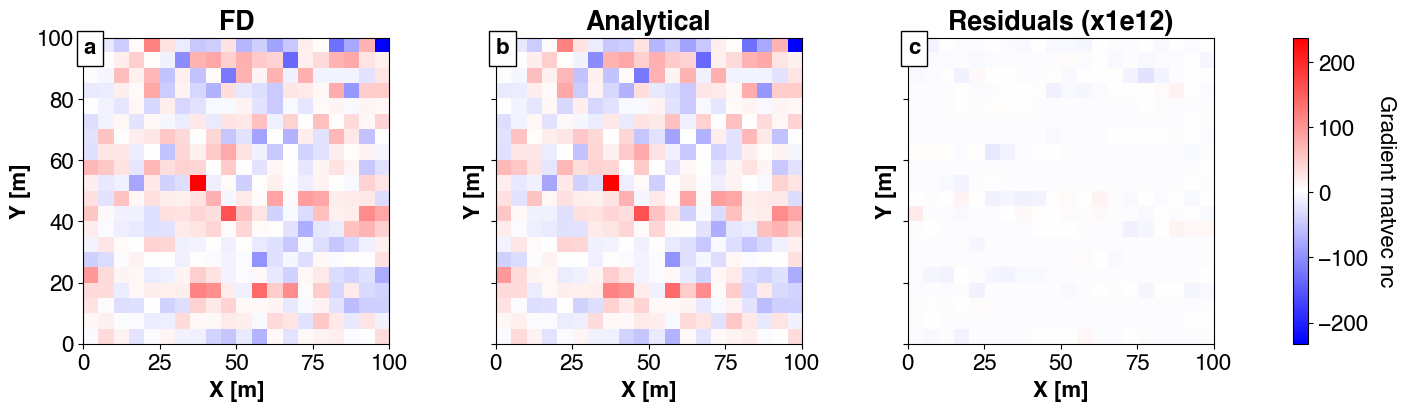

In [146]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 4)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "FD": fd_c_matvec,
        "Analytical": an_c_matvec,
        "Residuals (x1e12)": (fd_c_matvec - an_c_matvec) * 1e12,
    },
    cbar_title="Gradient matvec nc",
    imshow_kwargs={
        # "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        # "vmin": 0.0,
        # "vmax": 400,
        "aspect": "equal",
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.add_letter_to_frames(plotter.axes)

### Combination with the gradual deformation method

The following property forms the basis of the parameterization methods we're interested in:

Proposition 1. Let $(Z_i)_{i=0..N_e-1}$ be independent random variables of normal distribution $\mathcal{N}(\mu_{i},\sigma_{i}^{2})_{i=0..N_e-1}$ and $(a_i)_{i=0..N_e-1}$ be real numbers, then :

$$
Z = \displaystyle \sum^{N_e-1}_{i=0} a_i Z_i
$$

\noindent also follows a normal distribution $\mathcal{N}(\displaystyle\sum_{i=0}^{N_e-1} a_i\mu_{i},\displaystyle\sum_{i=0}^{N_e-1} a_{i}^{2} \sigma_{i}^{2})$

Property 1 implies that, for $Z_i$ following a centered-reduced normal distribution, if we choose the $a_i$ such that $\displaystyle\sum_{i=0}^{N_e-1} a_{i}^{2} =1$, the combination $Z = \displaystyle\sum_{i=0}^{N_e-1} a_{i} Z_i$ also follows a centered-reduced normal distribution.
Thus, from $N_{e}$ independent realizations of the geostatistical model, we can, thanks to a linear combination of Gaussian white noise, obtain a new one. The gradual deformation method consists in making the $a_i$ depend on a vector $\boldsymbol{\theta}$ with $N_{e}-1$ values, while ensuring that whatever the values in $\boldsymbol{\theta}$, $\displaystyle\sum_{i=0}^{N_e-1} a_{i}^{2}(\theta)=1$. To combine $N_{e}$ Gaussian white noise $(Z_0,...,Z_{N_{e}-1})$, we introduce $N_e -1$ parameters $\boldsymbol{\theta} = (\theta_{0},...,\theta_{N-2})$. The gradual deformation method is given by the following formula, which ensures that $\displaystyle\sum_{i=0}^{N_e-1} a_{i}^{2}(\theta)=1$:

$$
Z = \Bigg(\prod_{i=0}^{N_e-2} \cos(\theta_{i})\Bigg) Z_0 + \sum_{i=1}^{N_e-2} \Bigg(\sin(\theta_{i-1}) \prod_{j=i}^{N_e-2} \cos(\theta_{j}) \Bigg) Z_i + \Bigg(\sin(\theta_{Ne-2}) \Bigg) Z_{Ne-1}
$$



In [153]:
ne = 101

# array of white noises
W_test: NDArrayFloat = check_random_state(2023).normal(size=(nx * ny, ne))
# start with theta at zero
theta_test = check_random_state(265).normal(size=(ne - 1))
# theta_test = np.ones((ne - 1)) * 0.2


def get_gd_weights(theta: NDArrayFloat) -> NDArrayFloat:
    # initialize the vector of weights
    weights: NDArrayFloat = np.zeros((theta.size + 1))
    # first weight
    weights[0] = np.prod(np.cos(theta))
    # i = 1... Ne - 2
    for i in range(1, theta.size):
        weights[i] = np.sin(theta[i - 1]) * np.prod(np.cos(theta[i:]))
    # last weight
    weights[-1] = np.sin(theta[-1])
    # ensure that the sum of squared weights equals to one
    np.testing.assert_almost_equal(np.sum(weights**2), 1.0)
    return weights


def gd_parametrize(W: NDArrayFloat, weights: NDArrayFloat) -> NDArrayFloat:
    """
    Apply the gradual deformation parametrization to generate a new Z.

    Z is a random variable following a centered-reduced normal distribution.

    Parameters
    ----------
    z_arr : NDArrayFloat
        Array with size (N_z, Ne) which columns are independent random variables
        following a centered-reduced normal distribution of size (N_z).
        Ne is the number of independent realizations.
    weights : NDArrayFloat
        Gradual deformation weights.

    Returns
    -------
    NDArrayFloat
        New random variable following a centered-reduced normal distribution.
    """
    return np.sum(W * weights, axis=1)


weights_test = get_gd_weights(theta_test)
w_gd = gd_parametrize(W_test, weights_test)

logging.info(f"z_gd shape = {w_gd.shape}")
logging.info(f"mu z_gd = {np.mean(w_gd)}")  # expected is 0.0
logging.info(f"std z_gd = {np.std(w_gd)}")  # expected is 1.0

INFO:root:z_gd shape = (400,)
INFO:root:mu z_gd = -0.005357241486078883
INFO:root:std z_gd = 1.0514782474052606


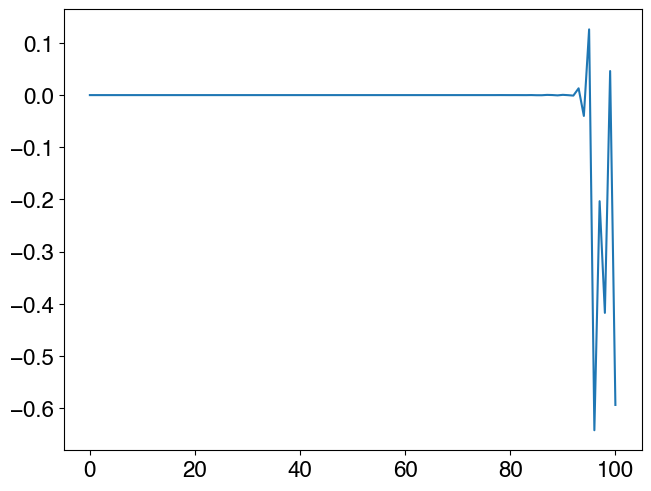

In [154]:
plt.plot(weights_test)

- Derivation of the gradual deformation variable change

We have

Considering the equations

$$
\mathbf{\xi} = \mathcal{D}(\boldsymbol{\theta})
$$

gathering we want to compute 

$$
\dfrac{\partial \mathbf{d}}{\partial \boldsymbol{\theta}} = \dfrac{\partial \mathcal{H} \circ \mathcal{G} \circ \mathcal{D} (\boldsymbol{\theta})}{\partial \theta} = \dfrac{\partial \mathcal{D} (\boldsymbol{\theta})}{\partial \theta} \dfrac{\partial \mathcal{G} (\mathbf{w})}{\partial \xi} \dfrac{\partial \mathcal{H} (\mathbf{s})}{\partial \mathbf{s}}
$$

considering a random vector

$$
\mathbf{b} = \dfrac{\partial \mathcal{G} (\mathbf{w})}{\partial \xi} \dfrac{\partial \mathcal{H} (\mathbf{s})}{\partial \mathbf{s}}
$$

we want to test the correctness of

$$
\dfrac{\partial \mathcal{D} (\boldsymbol{\theta})}{\partial \theta} \mathbf{b}
$$

with the SPDE approach. Note that it maps a gradient of size $N_{\xi}$ to $N_{e}-1$


In [149]:
def d_gd_parametrize_mat_vec(
    z_arr: NDArrayFloat, theta: NDArrayFloat, b: NDArrayFloat
) -> NDArrayFloat:
    """
    Apply the gradual deformation parametrization to generate a new Z.

    Z is a random variable following a centered-reduced normal distribution.

    Parameters
    ----------
    z_arr : NDArrayFloat
        Array with size (N_z, Ne) which columns are independent random variables
        following a centered-reduced normal distribution of size (N_z).
        Ne is the number of independent realizations.
    theta : NDArrayFloat
        Gradual deformation parameter.

    Returns
    -------
    NDArrayFloat
        New random variable following a centered-reduced normal distribution.
    """
    ne = theta.size + 1
    dweights: float = -np.prod(np.cos(theta)) / np.cos(theta) * np.sin(theta)
    # z0
    dz = dweights * (z_arr[:, 0] @ b)
    # z_ne -> the derivative only apply to the last element of \theta
    dweight = np.cos(theta[-1])
    dz[-1] += dweight * z_arr[:, -1] @ b

    # i = 1... Ne - 2
    for i in range(1, z_arr.shape[-1] - 1):
        v = z_arr[:, i] @ b
        # product
        tmp_prod = np.prod(np.cos(theta[i:]))
        # dealing with the sin
        dz[i - 1] += np.cos(theta[i - 1]) * tmp_prod * v
        # dealing with the cos product
        dz[i:] -= (
            np.sin(theta[i - 1]) * tmp_prod / np.cos(theta[i:]) * np.sin(theta[i:]) * v
        )

    return dz

In [150]:
def gd_parametrize_wrapper(theta: NDArrayFloat) -> NDArrayFloat:
    """theta is the gradual deformation vector."""
    return gd_parametrize(W_test, get_gd_weights(theta))


# compute the jacobian matrix
jac = nd.Jacobian(gd_parametrize_wrapper)(theta_test)

b = check_random_state(2023).normal(size=(nx * ny))
# Apply the jacobian to a vector
fd_gd_matvec = (jac.T @ b).reshape(10, 10)
# Derive analytically
# an_c_matvec = d_simu_c_matvec(
#     cholQ_init, Q_init_c, cholQ_init_c, dat_nn, dat_var_init, b
# ).reshape(nx, ny, order="F")
an_gd_matvec = d_gd_parametrize_mat_vec(W_test, theta_test, b).reshape(10, 10)

- plot the results

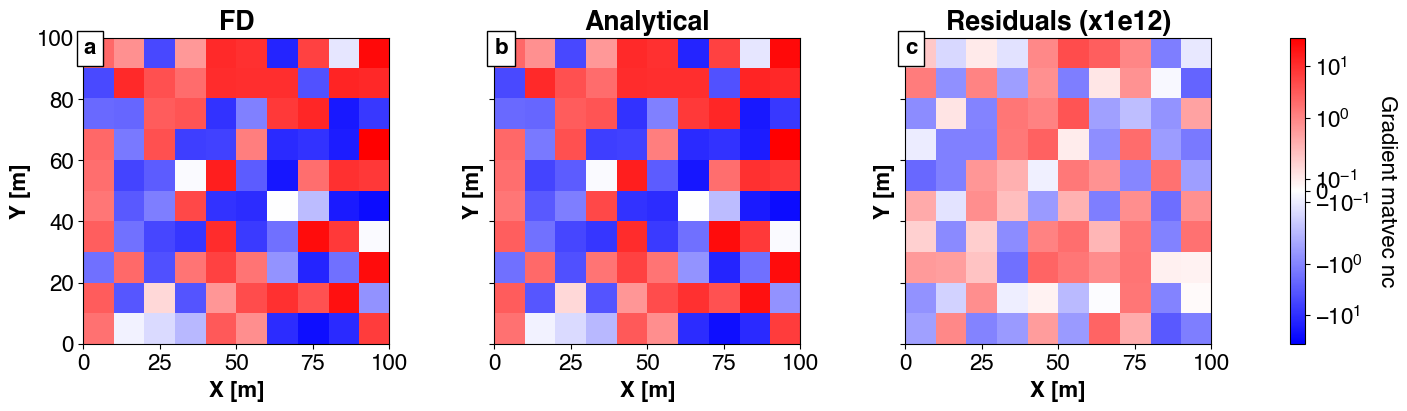

In [151]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 4)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "FD": fd_gd_matvec,
        "Analytical": an_gd_matvec,
        "Residuals (x1e12)": (fd_gd_matvec - an_gd_matvec) * 1e12,
    },
    cbar_title="Gradient matvec nc",
    imshow_kwargs={
        # "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        # "vmin": 0.0,
        # "vmax": 400,
        "aspect": "equal",
        "norm": mpl.colors.SymLogNorm(linthresh=0.5),
    },
    xlabel="X [m]",
    ylabel="Y [m]",
    is_symmetric_cbar=True,
)

ngp.add_letter_to_frames(plotter.axes)

$$
\begin{aligned}
\dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \theta_{0}} &= \left[- \displaystyle\prod_{j=0}^{N_e-2} \cos\left(\theta_{j} \right) \dfrac{ \sin\left( \theta_{0}\right)}{\cos\left(\theta_{0}\right)} \mathbf{W}_{0} + \cos\left( \theta_{0} \right)  \displaystyle \prod_{j=1}^{N_e-2} \cos\left( \theta_{j} \right) \mathbf{W}_{1} \right] \dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \mathbf{w}}
\\\\
\forall i \in [1, N_e - 3], \quad \dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \theta_{i}} &= \left[ \begin{array}{l} - \displaystyle\prod_{j=0}^{N_e-2} \cos\left(\theta_{j} \right) \dfrac{ \sin\left( \theta_{i}\right)}{\cos\left(\theta_{i}\right)} \mathbf{W}_{0} + \cos\left( \theta_{i} \right)  \displaystyle \prod_{j=i+1}^{N_e-2} \cos\left( \theta_{j} \right) \mathbf{W}_{i+1}
\\
- \displaystyle \sum_{j=1}^{i} \Bigg(\sin(\theta_{j-1}) \displaystyle \prod_{k=j}^{N_e-2} \cos(\theta_{k}) \dfrac{ \sin\left( \theta_{i}\right)}{\cos\left(\theta_{i}\right)} \Bigg) \mathbf{W}_{j} \end{array} \right] \dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \mathbf{w}}
\\\\
\dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \theta_{N_e - 2}}  &= \left[\begin{array}{l} - \displaystyle\sum_{j=1}^{N_e-2} \Bigg(\sin(\theta_{j-1}) \displaystyle \prod_{k=j}^{N_e-2} \cos(\theta_{k}) \dfrac{ \sin\left( \theta_{N_e-2}\right)}{\cos\left(\theta_{N_e-2}\right)} \Bigg) \mathbf{W}_{j} 
\\
- \displaystyle\prod_{j=0}^{N_e-2} \cos\left(\theta_{j} \right) \dfrac{ \sin\left( \theta_{N_e - 2}\right)}{\cos\left(\theta_{N_e - 2}\right)} \mathbf{W}_{0} + \cos\left( \theta_{N_{e}-2} \right) \mathbf{W}_{N_{e}-1} \end{array} \right] \dfrac{\partial \mathcal{J}(\mathbf{w})}{\partial \mathbf{w}}
\end{aligned}
$$

- Find the $\boldsymbol{\theta}$ so that all weights are equal at first

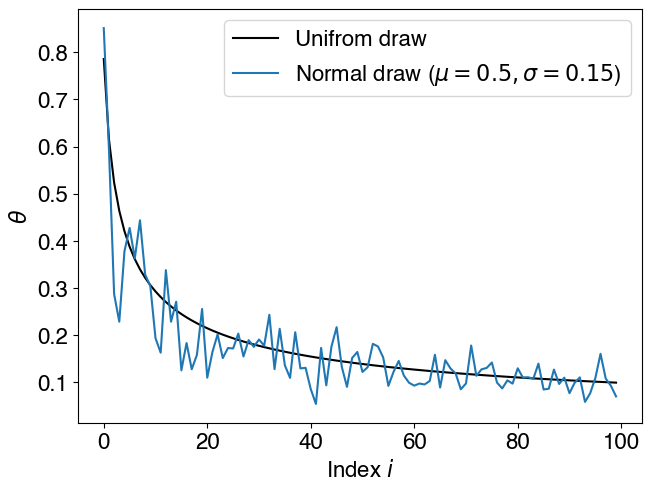

In [155]:
def _check_ne(ne: int) -> int:
    try:
        ne = int(ne)
        if ne < 2:
            raise ValueError
        return ne
    except (TypeError, ValueError) as err:
        raise ValueError("ne must be an integer, >=2.") from err


def get_theta_init_normal(
    ne: int,
    mu: float = 0.5,
    sigma: float = 0.15,
    random_state: Optional[
        Union[int, np.random.Generator, np.random.RandomState]
    ] = None,
) -> NDArrayFloat:
    """
    Get the initial theta vector such that ai are drawn from a normal distribution.

    Parameters
    ----------
    ne : int
        Number of realizations
    mu: float
        Mean of the normal distribution for a_i. The default is 0.5.
    sigma: float
        Standard deviation of the normal distribution for a_i. The default is 0.15.
    random_state : Optional[Union[int, np.random.Generator, np.random.RandomState]]
        Pseudorandom number generator state used to generate resamples.
        If `random_state` is ``None`` (or `np.random`), the
        `numpy.random.RandomState` singleton is used.
        If `random_state` is an int, a new ``RandomState`` instance is used,
        seeded with `random_state`.
        If `random_state` is already a ``Generator`` or ``RandomState``
        instance then that instance is used. The default is None

    Returns
    -------
    NDArrayFloat
        Vector of param theta with size (ne - 1).
    """
    a: NDArrayFloat = check_random_state(random_state).normal(
        loc=mu, scale=sigma, size=_check_ne(ne)
    )
    return get_theta_init(a / np.linalg.norm(a))


def get_theta_init_uniform(ne: int) -> NDArrayFloat:
    """
    Get the initial theta vector so all weights ai are the same (1/ne).

    Parameters
    ----------
    ne : int
        Number of realizations

    Returns
    -------
    NDArrayFloat
        Vector of param theta with size (ne - 1).
    """
    ne = _check_ne(ne)
    return get_theta_init(np.ones(ne) / np.sqrt(ne))


def get_theta_init(target_weights: NDArrayFloat) -> NDArrayFloat:
    """
    Get the initial theta vector to ensure the given target weights.

    Parameters
    ----------
    target_weights : NDArrayFloat
        Target weights with size (Ne,).

    Returns
    -------
    NDArrayFloat
        Vector of param theta with size (ne - 1).
    """
    ne = np.size(target_weights)
    params = np.zeros((ne - 1))
    params[-1] = np.arcsin(target_weights[-1])

    # i = 1... Ne - 2
    for i in range(ne - 3, -1, -1):
        params[i] = np.arcsin(target_weights[i + 1] / np.prod(np.cos(params[i + 1 :])))
    return params


theta_init = get_theta_init_uniform(ne)
ai = np.random.default_rng(2024).normal(loc=0.5, scale=0.15, size=ne)
ai = ai / np.linalg.norm(ai)
theta_init_random = get_theta_init(ai)
# All initial weights should have the same value = no white noise is more important than another
# target_weights = np.sqrt(np.ones(ne) / ne)

# Test that this is working fine
# np.testing.assert_allclose(gd_parametrize(z_arr_test, theta_init)[1], target_weights)

gd_parametrize(W_test, get_gd_weights(theta_init))
plt.plot(theta_init, label="Uniform draw", c="k")
plt.plot(theta_init_random, label=r"Normal draw ($\mu=0.5, \sigma=0.15$)")
plt.xlabel("Index $i$")
plt.ylabel(r"$\theta$")
plt.legend()
plt.savefig(fig_save_path.joinpath("initial_theta_weights.pdf"), format="pdf")

In [63]:
ne, mu, sigma, random_state = (100, 0.5, 0.15, 2015)

theta_init = get_theta_init_normal(ne, mu=mu, sigma=sigma, random_state=random_state)
a = check_random_state(random_state).normal(loc=mu, scale=sigma, size=ne)
expected_a = a / np.linalg.norm(a)
theta_init
# np.testing.assert_allclose(get_gd_weights(theta_init), expected_a)

array([0.        , 0.81117742, 0.43151243, 0.5146847 , 0.46852367,
       0.18534148, 0.22669057, 0.22218891, 0.23078905, 0.24048858,
       0.34988784, 0.16499138, 0.27401002, 0.1571064 , 0.27206445,
       0.28721762, 0.20595736, 0.20895517, 0.11563032, 0.18707433,
       0.19166409, 0.33499727, 0.13817495, 0.2435639 , 0.19747184,
       0.24361377, 0.18642594, 0.21437798, 0.23824457, 0.18134177,
       0.12640017, 0.08192216, 0.20656884, 0.23279274, 0.19108935,
       0.07689462, 0.2065338 , 0.11970055, 0.07803555, 0.12850868,
       0.15037696, 0.10910203, 0.17076012, 0.20163779, 0.15083104,
       0.15698433, 0.13873251, 0.11892632, 0.11578716, 0.17544839,
       0.15264014, 0.12910889, 0.17393953, 0.09367853, 0.15291875,
       0.09316959, 0.13485124, 0.1309722 , 0.06265218, 0.11250599,
       0.09409764, 0.05660438, 0.09288355, 0.1837054 , 0.14138205,
       0.08530194, 0.15346858, 0.08897474, 0.10815496, 0.13417176,
       0.18231088, 0.16463911, 0.09860922, 0.0880656 , 0.13971

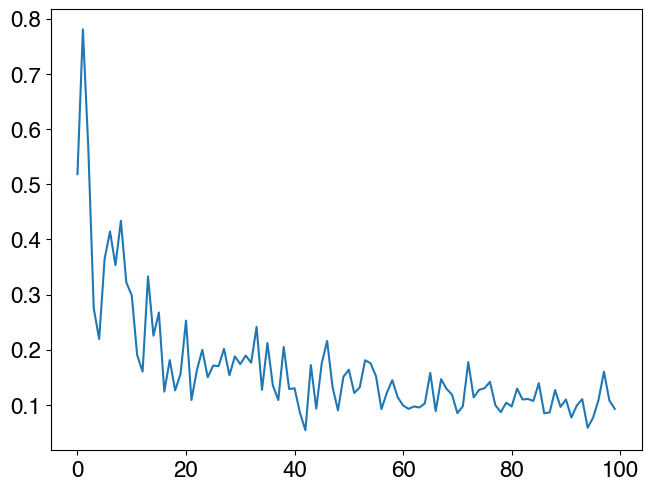

In [30]:
plt.plot(theta_init_random)

## Merging all operators

- Non conditional simulations

In [31]:
# We will use the previous white noise
def ls_simu_nc_params(theta_cur: NDArrayFloat) -> float:
    return ls_simu_nc(gd_parametrize(W_test, get_gd_weights(theta_cur)))


def ls_simu_nc_params_grad(theta_cur: NDArrayFloat) -> NDArrayFloat:
    s_cur = (
        spde.simu_nc(
            cholQ_init,
            w=gd_parametrize(W_test, get_gd_weights(theta_cur)),
        )
        + estimated_mean
    )
    # gradient with respect to the objective function
    grad: NDArrayFloat = 2 * (s_cur - reference_grade_ppm.ravel("F"))
    # chain the operators
    return d_gd_parametrize_mat_vec(
        W_test, theta_cur, d_simu_nc_mat_vec(cholQ_init, grad)
    )


# finite difference gradient
fd_grad_ls_nc = finite_gradient(theta_init, ls_simu_nc_params, max_workers=6).reshape(
    10, 10, order="F"
)

# analytical gradient: "A^{-1}x - b"^2  ==> Gradient = 2A^{T} (A^{-1} x - b)
an_grad_ls_nc = ls_simu_nc_params_grad(theta_init).reshape(10, 10, order="F")

ValueError: operands could not be broadcast together with shapes (400,101) (100,) 

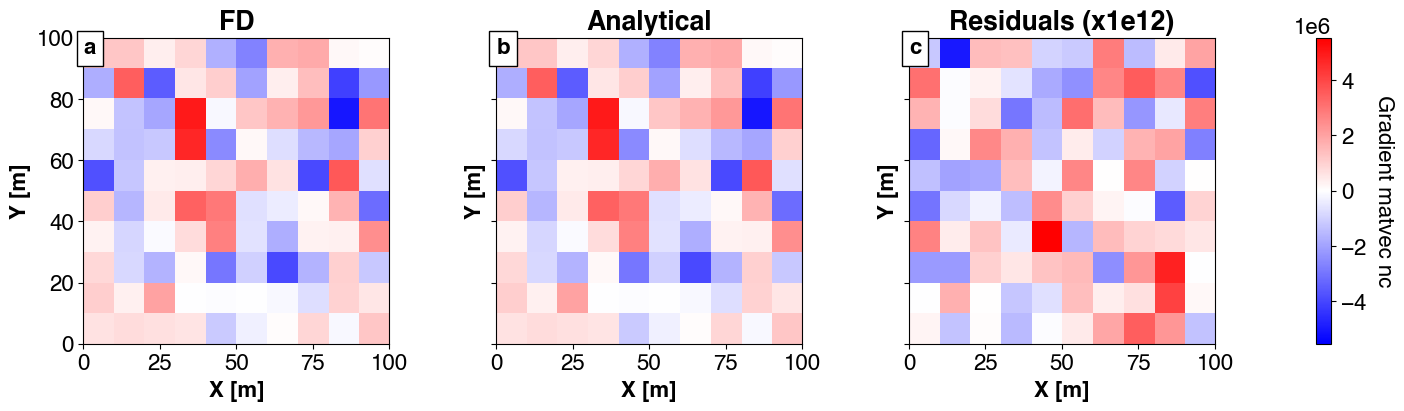

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 4)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "FD": fd_grad_ls_nc,
        "Analytical": an_grad_ls_nc,
        "Residuals (x1e12)": (fd_grad_ls_nc - an_grad_ls_nc) * 1e10,
    },
    cbar_title="Gradient matvec nc",
    imshow_kwargs={
        # "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        # "vmin": 0.0,
        # "vmax": 400,
        "aspect": "equal",
        # "norm": mpl.colors.SymLogNorm(linthresh=0.5),
    },
    xlabel="X [m]",
    ylabel="Y [m]",
    is_symmetric_cbar=True,
)

ngp.add_letter_to_frames(plotter.axes)

- Conditional simulations

In [ ]:
def ls_simu_cond(w: NDArrayFloat) -> float:
    """w is the Gaussian white noise."""
    s_cur = (
        spde.simu_c(
            cholQ_init,
            Q_init_c,
            cholQ_init_c,
            dat_val_noisy - estimated_mean,
            dat_nn,
            dat_var_init,
            w=w,
        )
        + estimated_mean
    )
    return eval_loss(reference_grade_ppm.ravel("F"), s_cur)


# We will use the previous white noise
def ls_simu_cond_params(theta_cur: NDArrayFloat) -> float:
    return ls_simu_cond(gd_parametrize(W_test, get_gd_weights(theta_cur)))


def ls_simu_cond_params_grad(theta_cur: NDArrayFloat) -> NDArrayFloat:
    s_cur = (
        spde.simu_c(
            cholQ_init,
            Q_init_c,
            cholQ_init_c,
            dat_val_noisy - estimated_mean,
            dat_nn,
            dat_var_init,
            w=gd_parametrize(W_test, get_gd_weights(theta_cur)),
        )
        + estimated_mean
    )
    # gradient with respect to the objective function
    grad: NDArrayFloat = 2 * (s_cur - reference_grade_ppm.ravel("F"))
    # chain the operators
    return d_gd_parametrize_mat_vec(
        W_test,
        theta_cur,
        d_simu_c_matvec(cholQ_init, cholQ_init_c, dat_nn, dat_var_init, grad),
    )


# finite difference gradient
fd_grad_ls_cond = finite_gradient(
    theta_init, ls_simu_cond_params, max_workers=6
).reshape(10, 10, order="F")

# analytical gradient: "A^{-1}x - b"^2  ==> Gradient = 2A^{T} (A^{-1} x - b)
an_grad_ls_cond = ls_simu_cond_params_grad(theta_init).reshape(10, 10, order="F")

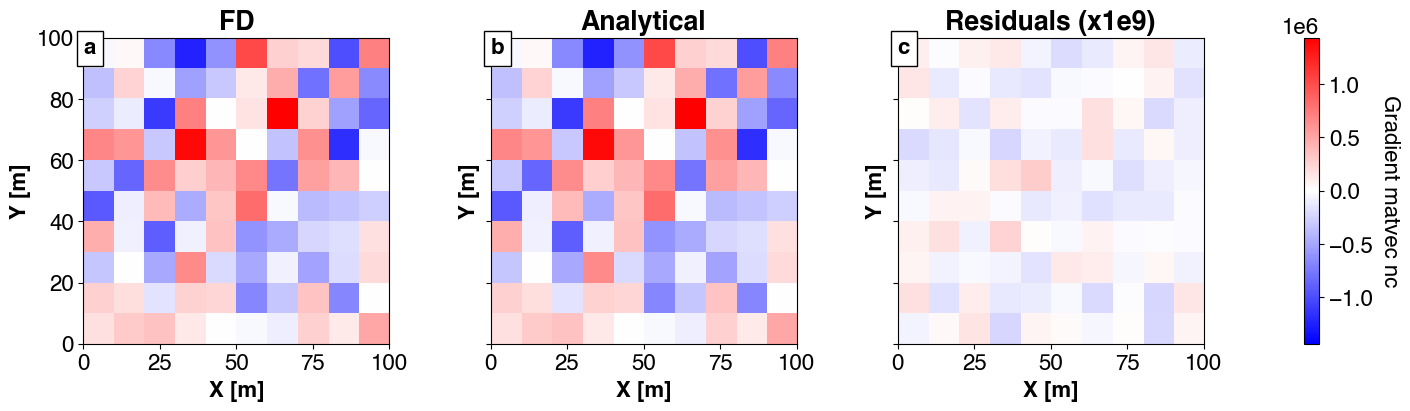

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 4)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "FD": fd_grad_ls_cond,
        "Analytical": an_grad_ls_cond,
        "Residuals (x1e9)": (fd_grad_ls_cond - an_grad_ls_cond) * 1e9,
    },
    cbar_title="Gradient matvec nc",
    imshow_kwargs={
        # "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        # "vmin": 0.0,
        # "vmax": 400,
        "aspect": "equal",
        # "norm": mpl.colors.SymLogNorm(linthresh=0.5),
    },
    xlabel="X [m]",
    ylabel="Y [m]",
    is_symmetric_cbar=True,
)

ngp.add_letter_to_frames(plotter.axes)

## Test preconditioner classes

In [ ]:
from abc import ABC, abstractmethod
from typing import Optional, Sequence

from pyrtid.utils.types import NDArrayFloat


class Preconditioner(ABC):
    """
    This an asbract class for parameter preconditioning and parametrization.

    This class provides an interface for adjusted variables preconditioning i.e.,
    application of a transformation, that conditions a given problem into a form that
    is more suitable for numerical solving methods. The interface is the same for
    parametrization, i.e. reduction of the number of adjusted values.
    """

    def __init__(self, eps: Optional[float] = None) -> None:
        """
        Initialize the instance.

        Parameters
        ----------
        eps: float
            The epsilon for the computation of the approximated preconditioner first
            derivative by finite difference.
        """
        self.eps: float | None = eps

    @abstractmethod
    def transform(self, s_raw: NDArrayFloat) -> NDArrayFloat:
        """Apply the preconditioning/parametrization."""
        ...  # pragma: no cover

    @abstractmethod
    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """Apply the back-preconditioning/parametrization."""
        ...  # pragma: no cover

    @abstractmethod
    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.

        Because the preconditioner operates a variable change in the function: the new
        objective function J is J2(s2) = J[s], with s the adjusted parameter vector.
        Then the gradient is dJ2/ds2 = ds/ds2 * dJ/ds.

        - Example 1 : we defined s2 = k * s -> dJ2/ds2 = ds/ds2 dJ/ds = 1/k * dj/ds. If
        k = 1/100 --> the gradient is a 100 times stronger. The parameter update is
        performed on s2 and not on s.
        - Example 2: we defined s2 = log(s) -> dJ2/ds2 = ds/ds2 dJ/ds = s * dj/ds

        Often, it is more efficient to compute (ds/ds2 * dJ/ds) directly
        than to return ds/ds2, espectially if ds/ds2 is a matrix of large dimension.

        Parameters
        ----------
        b : NDArrayFloat
            Any vector with size $N_{s}$.

        Returns
        -------
        NDArrayFloat
            Product of the 1st derivative w.r.t. the conditioned values and any vector
            b with size $N_{s}$.
        """
        ...  # pragma: no cover

    def _get_test_data(
        self,
        lbounds: Union[float, NDArrayFloat],
        ubounds: Union[float, NDArrayFloat],
        shape: Optional[Union[int, Sequence[int]]] = None,
    ) -> NDArrayFloat:
        """
        Get test data to check the preconditioner correctness.

        This is a development tool.
        """
        _lbounds, _ubounds = np.array(lbounds), np.array(ubounds)
        _lbounds[np.isneginf(_lbounds)] = -1e10
        _ubounds[np.isposinf(_ubounds)] = +1e10
        if shape is None:
            _size = np.size(lbounds)
            if _size == 1:
                _size = (50,)
        else:
            _size = shape
        # uniform sampling
        test_data: NDArrayFloat = np.random.default_rng(2023).uniform(
            low=_lbounds, high=_ubounds, size=_size
        )
        return test_data

    def _test_preconditioner(
        self,
        lbounds: Union[float, NDArrayFloat],
        ubounds: Union[float, NDArrayFloat],
        shape: Optional[Union[int, Sequence[int]]] = None,
    ) -> None:
        """
        Test if the backconditioner is the inverse of the preconditioner.

        This is a development tool.
        """
        # Add a small epsilon to avoid boundary cases
        test_data = self._get_test_data(lbounds=lbounds, ubounds=ubounds, shape=shape)

        # 1) check if the back and pre-conditioner match
        if not np.allclose(test_data, self.backtransform(self.transform(test_data))):
            raise ValueError(
                "The given backconditioner does not match the preconditioner! or"
                " the provided bounds are not correct."
            )

        print(self.dtransform_vec(test_data, test_data))
        print(
            nd.Jacobian(self.backtransform, step=self.eps)(self.transform(test_data)).T
            @ test_data
        )
        # 2) check by finite difference if the pre-conditioner 1st derivative is correct
        np.testing.assert_allclose(
            self.dtransform_vec(test_data, test_data),
            # Finite difference differentiation
            nd.Jacobian(self.backtransform, step=self.eps)(self.transform(test_data)).T
            @ test_data,  # type: ignore
            rtol=1e-5,
        )


class SqrtTransform(Preconditioner):
    """Apply a sqrt preconditioning to ensure positive values of the parameter."""

    def transform(self, s_raw: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the preconditioning/parametrization.

        Parameters
        ----------
        s_raw : NDArrayFloat
            Non-conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Conditioned parameter values.
        """
        return np.sqrt(s_raw)

    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the back-preconditioning/parametrization.

        Parameters
        ----------
        s_cond : NDArrayFloat
            Conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Non-conditioned parameter values.
        """
        return np.square(s_cond)

    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.
        """
        return 2.0 * np.sqrt(s_raw) * gradient


class LogTransform(Preconditioner):
    """Apply a sqrt preconditioning to ensure positive values of the parameter."""

    def transform(self, s_raw: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the preconditioning/parametrization.

        Parameters
        ----------
        s_raw : NDArrayFloat
            Non-conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Conditioned parameter values.
        """
        return np.log(s_raw)

    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the back-preconditioning/parametrization.

        Parameters
        ----------
        s_cond : NDArrayFloat
            Conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Non-conditioned parameter values.
        """
        return np.exp(s_cond)

    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.
        """
        return s_raw * gradient


class Normalizer(Preconditioner):
    """Apply a sqrt preconditioning to ensure positive values of the parameter."""

    def __init__(self, s_prior: NDArrayFloat, eps: float | None = None) -> None:
        super().__init__(eps)
        # mean value of the prior field
        self.prior_mean = np.mean(s_prior)
        # standard deviation of the prior field
        self.prior_std = np.std(s_prior)

    def transform(self, s_cur: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the preconditioning/parametrization.

        Parameters
        ----------
        s_raw : NDArrayFloat
            Non-conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Conditioned parameter values.
        """
        return (s_cur - self.prior_mean) / self.prior_std

    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the back-preconditioning/parametrization.

        Parameters
        ----------
        s_cond : NDArrayFloat
            Conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Non-conditioned parameter values.
        """
        return s_cond * self.prior_std + self.prior_mean

    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.
        """
        return self.prior_std * gradient


class StdRescaler(Preconditioner):
    """Apply a sqrt preconditioning to ensure positive values of the parameter."""

    def __init__(
        self,
        s_prior: NDArrayFloat,
        prior_std: Optional[float] = None,
        eps: float | None = None,
    ) -> None:
        super().__init__(eps)
        # need to store the prior field for the rescaling
        self.s_prior = s_prior

        # store to avoid computing many times
        if prior_std is None:
            self.prior_std: float = float(np.std(self.s_prior))
        else:
            self.prior_std = prior_std

    def transform(self, s_cur: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the preconditioning/parametrization.

        Parameters
        ----------
        s_raw : NDArrayFloat
            Non-conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Conditioned parameter values.
        """
        return (s_cur - self.s_prior) / self.prior_std

    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the back-preconditioning/parametrization.

        Parameters
        ----------
        s_cond : NDArrayFloat
            Conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Non-conditioned parameter values.
        """
        return s_cond * self.prior_std + self.s_prior

    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.
        """
        return self.prior_std * gradient


class BoundsRescaler(Preconditioner):
    """Apply a bound rescaling (aka logit)."""

    EPSILON = 1e-10

    def __init__(
        self,
        lbounds: NDArrayFloat,
        ubounds: NDArrayFloat,
        eps: Optional[float] = None,
    ) -> None:
        super().__init__(eps)
        # need to store bounds for the rescaling process
        self.lbounds = lbounds
        self.ubounds = ubounds

    def transform(self, s_cur: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the preconditioning/parametrization.

        Parameters
        ----------
        s_raw : NDArrayFloat
            Non-conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Conditioned parameter values.
        """
        # clip to bounds with very small values to avoid negative values in the log
        _s_cur = s_cur.clip(self.lbounds + self.EPSILON, self.ubounds - self.EPSILON)
        return np.log((_s_cur - self.lbounds) / (self.ubounds - _s_cur))

    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the back-preconditioning/parametrization.

        Parameters
        ----------
        s_cond : NDArrayFloat
            Conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Non-conditioned parameter values.
        """
        bounds_mean = 0.5 * (self.ubounds + self.lbounds)
        bounds_half_amplitude = 0.5 * (self.ubounds - self.lbounds)
        return bounds_mean + bounds_half_amplitude * (
            (np.exp(s_cond) - 1) / (np.exp(s_cond) + 1)
        )

    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.
        """
        _s_cur = s_raw.clip(self.lbounds + self.EPSILON, self.ubounds - self.EPSILON)
        return (
            -((_s_cur - self.lbounds) * (_s_cur - self.ubounds))
            / (self.ubounds - self.lbounds)
            * gradient
        )


def get_gd_weights(theta: NDArrayFloat) -> NDArrayFloat:
    if np.size(theta) < 1:
        raise ValueError("The theta vector is empty!")
    # initialize the vector of weights
    weights: NDArrayFloat = np.zeros((theta.size + 1))
    # first weight
    weights[0] = np.prod(np.cos(theta))
    # i = 1... Ne - 2
    for i in range(1, theta.size):
        weights[i] = np.sin(theta[i - 1]) * np.prod(np.cos(theta[i:]))
    # last weight
    weights[-1] = np.sin(theta[-1])
    # ensure that the sum of squared weights equals to one
    np.testing.assert_almost_equal(np.sum(weights**2), 1.0)
    return weights


def gd_parametrize(W: NDArrayFloat, weights: NDArrayFloat) -> NDArrayFloat:
    """
    Apply the gradual deformation parametrization to generate a new Z.

    Z is a random variable following a centered-reduced normal distribution.

    Parameters
    ----------
    z_arr : NDArrayFloat
        Array with size (N_z, Ne) which columns are independent random variables
        following a centered-reduced normal distribution of size (N_z).
        Ne is the number of independent realizations.
    weights : NDArrayFloat
        Gradual deformation weights.

    Returns
    -------
    NDArrayFloat
        New random variable following a centered-reduced normal distribution.
    """
    return np.sum(W * weights, axis=1)


def d_gd_parametrize_mat_vec(
    z_arr: NDArrayFloat, theta: NDArrayFloat, b: NDArrayFloat
) -> NDArrayFloat:
    """
    Apply the gradual deformation parametrization to generate a new Z.

    Z is a random variable following a centered-reduced normal distribution.

    Parameters
    ----------
    z_arr : NDArrayFloat
        Array with size (N_z, Ne) which columns are independent random variables
        following a centered-reduced normal distribution of size (N_z).
        Ne is the number of independent realizations.
    theta : NDArrayFloat
        Gradual deformation parameter.

    Returns
    -------
    NDArrayFloat
        New random variable following a centered-reduced normal distribution.
    """
    theta.size + 1
    dweights: float = -np.prod(np.cos(theta)) / np.cos(theta) * np.sin(theta)
    # z0
    dz = dweights * (z_arr[:, 0] @ b)
    # z_ne -> the derivative only apply to the last element of \theta
    dweight = np.cos(theta[-1])
    dz[-1] += dweight * z_arr[:, -1] @ b

    # i = 1... Ne - 2
    for i in range(1, z_arr.shape[-1] - 1):
        v = z_arr[:, i] @ b
        # product
        tmp_prod = np.prod(np.cos(theta[i:]))
        # dealing with the sin
        dz[i - 1] += np.cos(theta[i - 1]) * tmp_prod * v
        # dealing with the cos product
        dz[i:] -= (
            np.sin(theta[i - 1]) * tmp_prod / np.cos(theta[i:]) * np.sin(theta[i:]) * v
        )

    return dz


def get_theta_init(ne: int) -> NDArrayFloat:
    """
    Get the initial theta vector so all weights ai are the same (1/ne).

    Parameters
    ----------
    ne : int
        Number of realizations

    Returns
    -------
    NDArrayFloat
        Vector of param theta with size (ne - 1).
    """
    try:
        ne = int(ne)
        if ne < 2:
            raise ValueError
    except (TypeError, ValueError) as err:
        raise ValueError("ne must be an integer, >=2.") from err

    target_weight = np.sqrt(1 / ne)
    params = np.zeros((ne - 1))
    params[-1] = np.arcsin(target_weight)

    # i = 1... Ne - 2
    for i in range(ne - 2, 0, -1):
        params[i] = np.arcsin(target_weight / np.prod(np.cos(params[i + 1 :])))

    params[0] = np.arccos(target_weight / np.prod(np.cos(params[1:])))

    return params


class GDPNCS(Preconditioner):
    """
    Apply a Gradual Deformation parametrization associated with the SPDE approach.

    The Gradual Deformation parametrization is used to generate a white noise
    reduced and centered as a linear combinaison of Ne white noises while adjusting
    Ne-1 parameters. The obtained white noise is used in the SPDE approach to
    generate a field with the required geostatistical parameters.

    Here: non conditional-simulation.

    TODO: add ref.
    """

    def __init__(
        self,
        ne: int,
        Q_nc: csc_array,
        estimated_mean: float,
        theta: Optional[NDArrayFloat] = None,
        eps: Optional[float] = None,
        cholQ_nc: Optional[Factor] = None,
        random_state: Optional[
            Union[int, np.random.Generator, np.random.RandomState]
        ] = None,
    ) -> None:
        """
        Initialize the instance.

        Parameters
        ----------
        eps: float
            The epsilon for the computation of the approximated preconditioner first
            derivative by finite difference.
        random_state : Optional[Union[int, np.random.Generator, np.random.RandomState]]
            Pseudorandom number generator state used to generate resamples.
            If `random_state` is ``None`` (or `np.random`), the
            `numpy.random.RandomState` singleton is used.
            If `random_state` is an int, a new ``RandomState`` instance is used,
            seeded with `random_state`.
            If `random_state` is already a ``Generator`` or ``RandomState``
            instance then that instance is used. The default is None
        """
        # initialize the super instance
        super().__init__(eps=eps)

        self.estimated_mean = estimated_mean

        # perform the cholesky factorization of the sparse non conditional precision
        # matrix for fast inversion
        if cholQ_nc is None:
            self._cholQ_nc = cholesky(Q_nc)
        else:
            self._cholQ_nc = cholQ_nc

        # initialize the ensemble of white noises with shape (Ns, Ne)
        self.W: NDArrayFloat = check_random_state(random_state).normal(
            size=(Q_nc.shape[0], ne)
        )

        if theta is not None:
            # check the length correctness
            assert np.size(theta) == ne - 1
            self.theta = theta
        else:
            # initialize theta such as weights (ai) are all equals (1/sqrt(Ne)).
            self.theta: NDArrayFloat = get_theta_init(ne)

    def _get_test_data(
        self,
        lbounds: Union[float, NDArrayFloat],
        ubounds: Union[float, NDArrayFloat],
        shape: Optional[Union[int, Sequence[int]]] = None,
    ) -> NDArrayFloat:
        """
        Get test data to check the preconditioner correctness.

        This is a development tool.
        """
        return self.backtransform(self.theta)

    def transform(self, s_raw: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the preconditioning/parametrization.

        It works a bit differently for this preconditioner -> the value is not taken
        from the model.

        Parameters
        ----------
        s_raw : NDArrayFloat
            Non-conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Conditioned parameter values.
        """
        return self.theta

    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the back-preconditioning/parametrization.

        Parameters
        ----------
        s_cond : NDArrayFloat
            Conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Non-conditioned parameter values.
        """
        # assign the updated values TODO: see if it works fine
        self.theta = s_cond
        return (
            spde.simu_nc(
                self._cholQ_nc,
                w=gd_parametrize(self.W, get_gd_weights(self.theta)),
            )
            + self.estimated_mean
        )

    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.
        """
        return d_gd_parametrize_mat_vec(
            self.W, self.theta, spde.d_simu_nc_mat_vec(self._cholQ_nc, gradient)
        )


class GDPCS(GDPNCS):
    """
    Apply a Gradual Deformation parametrization associated with the SPDE approach.

    The Gradual Deformation parametrization is used to generate a white noise
    reduced and centered as a linear combinaison of Ne white noises while adjusting
    Ne-1 parameters. The obtained white noise is used in the SPDE approach to
    generate a field with the required geostatistical parameters.

    Here: conditional-simulation.

    TODO: add ref.
    """

    def __init__(
        self,
        ne: int,
        Q_nc: csc_array,
        Q_c: csc_array,
        estimated_mean: float,
        dat_nn: NDArrayInt,
        dat_val: NDArrayFloat,
        dat_var: NDArrayFloat,
        theta: Optional[NDArrayFloat] = None,
        eps: Optional[float] = None,
        cholQ_nc: Optional[Factor] = None,
        cholQ_c: Optional[Factor] = None,
        random_state: Optional[
            Union[int, np.random.Generator, np.random.RandomState]
        ] = None,
    ) -> None:
        """
        Initialize the instance.

        Parameters
        ----------
        eps: float
            The epsilon for the computation of the approximated preconditioner first
            derivative by finite difference.
        random_state : Optional[Union[int, np.random.Generator, np.random.RandomState]]
            Pseudorandom number generator state used to generate resamples.
            If `random_state` is ``None`` (or `np.random`), the
            `numpy.random.RandomState` singleton is used.
            If `random_state` is an int, a new ``RandomState`` instance is used,
            seeded with `random_state`.
            If `random_state` is already a ``Generator`` or ``RandomState``
            instance then that instance is used. The default is None
        """
        # initialize the super instance
        super().__init__(
            ne=ne,
            Q_nc=Q_nc,
            estimated_mean=estimated_mean,
            theta=theta,
            eps=eps,
            cholQ_nc=cholQ_nc,
            random_state=random_state,
        )

        # perform the cholesky factorization of the sparse non conditional precision
        # matrix for fast inversion
        if cholQ_c is None:
            self._cholQ_c = cholesky(Q_c)
        else:
            self._cholQ_c = cholQ_c
        self._Q_c = Q_c

        # Conditioning data
        self.dat_nn = dat_nn
        self.dat_val = dat_val
        self.dat_var = dat_var

    def transform(self, s_raw: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the preconditioning/parametrization.

        It works a bit differently for this preconditioner -> the value is not taken
        from the model.

        Parameters
        ----------
        s_raw : NDArrayFloat
            Non-conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Conditioned parameter values.
        """
        return self.theta

    def backtransform(self, s_cond: NDArrayFloat) -> NDArrayFloat:
        """
        Apply the back-preconditioning/parametrization.

        Parameters
        ----------
        s_cond : NDArrayFloat
            Conditioned parameter values.

        Returns
        -------
        NDArrayFloat
            Non-conditioned parameter values.
        """
        # assign the updated values TODO: see if it works fine
        self.theta = s_cond
        return (
            spde.simu_c(
                self._cholQ_nc,
                self._Q_c,
                self._cholQ_c,
                self.dat_val - self.estimated_mean,
                self.dat_nn,
                self.dat_var,
                w=gd_parametrize(self.W, get_gd_weights(self.theta)),
            )
            + self.estimated_mean
        )

    def dtransform_vec(
        self, s_raw: NDArrayFloat, gradient: NDArrayFloat
    ) -> NDArrayFloat:
        """
        Return the transform gradient of a function to match the new parameter.
        """
        return d_gd_parametrize_mat_vec(
            self.W,
            self.theta,
            spde.d_simu_c_matvec(
                self._cholQ_nc, self._cholQ_c, self.dat_nn, self.dat_var, gradient
            ),
        )

In [ ]:
precond = SqrtTransform(eps=1e-6)

lbounds = np.ones((3))
ubounds = np.array([1.2, 2.5, 25.5])

precond._get_test_data(lbounds=lbounds, ubounds=ubounds)
precond._test_preconditioner(lbounds=lbounds, ubounds=ubounds)

[ 2.0530646   3.06994561 14.65563718]
[ 2.0530646   3.06994561 14.65563718]


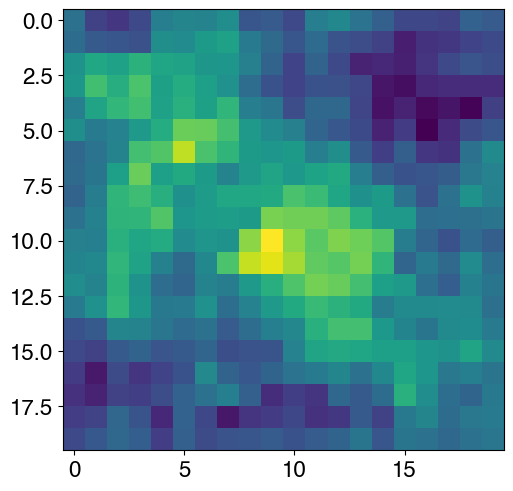

In [ ]:
pnc = GDPNCS(ne, Q_init, nx * ny, float(estimated_mean), random_state=2024)
plt.imshow(pnc.backtransform(pnc.theta).reshape(nx, ny, order="F"))

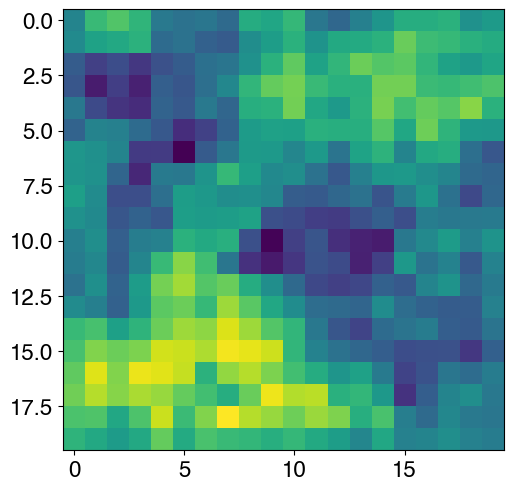

In [ ]:
pnc = GDPCS(
    ne,
    Q_init,
    Q_init_c,
    nx * ny,
    float(estimated_mean),
    dat_nn,
    dat_val,
    dat_var_init,
    random_state=2024,
)
plt.imshow(pnc.backtransform(pnc.theta).reshape(nx, ny, order="F"))

In [ ]:
ne

101

In [ ]:
lbounds = np.ones((nx * ny)) * -1000
ubounds = np.ones((nx * ny)) * 1500


theta_test = np.ones(ne - 1)

pcd = GDPNCS(ne, Q_init, nx * ny, estimated_mean)

pcd._get_test_data(lbounds, ubounds)
pcd.transform(pcd._get_test_data(lbounds, ubounds))

pcd = GDPNCS(ne, Q_init, nx * ny, estimated_mean)

# pcd._test_preconditioner(lbounds, ubounds)

pcd.theta = get_theta_init(ne) * (
    1 + 0.1 * np.random.default_rng(2024).normal(size=ne - 1)
)
pcd._test_preconditioner(lbounds, ubounds)

[ 8.81486404e+04  2.52768724e+03  1.04799655e+06  5.75274259e+05
 -4.46560611e+05  7.81372258e+04 -1.63359323e+05  2.36869221e+05
  9.68612267e+04 -1.46077677e+06 -2.55960925e+05 -1.25779471e+05
  1.09108155e+06 -1.12612294e+06  5.04553467e+05  1.35946719e+06
 -7.60154750e+05 -5.11409963e+05 -1.32659083e+06 -2.17198061e+05
  6.66009481e+04  1.25203499e+06 -7.37963198e+05 -3.64990224e+05
  1.80037857e+05  7.08306680e+05  5.34816676e+05 -3.46354313e+05
  8.46418052e+05 -7.67863704e+05 -5.44852269e+05  1.89654808e+05
 -1.34371489e+06 -3.89062711e+05  1.42436330e+06  6.86336278e+05
 -3.37522080e+05 -3.22863579e+05  3.94506867e+05  2.46551323e+06
  1.75847173e+05  4.87188453e+05  2.08075075e+06 -1.26329802e+06
 -7.27159239e+05 -9.65376270e+05 -4.28083776e+05 -6.82917122e+05
  6.43285757e+05 -2.45127836e+05  3.00307536e+05 -8.86772047e+05
 -1.28562487e+06  5.17333261e+05 -2.38525682e+06  4.96307657e+05
 -9.75387834e+05  4.80535681e+05  4.34730515e+05 -1.89541307e+05
 -7.20155055e+04 -4.57638

# TODO: ensure positivity
# TODO: test with an optimization (reconstruction)